# Evaluation Metrics

What is Text Similarity?

Determining the closeness of two pieces of text or document in terms of surface meaning or implied meaning is called text similarity. 


There are two ways to measure text similarity:


1. Lexical similarity: If the similarity is decided based on the surface meaning.

Example: 

a. Her face lit up.

b. Her candle lit up itself.


The two sentences a and b are mostly composed of same set of words: 'Her', 'lit' and 'up'. This makes them lexically similar. Although the meaning conveyed by them is very different. 


2. Semantic similarity: If the similarity is decided based on the implied meaning.

Example: 

a. It is Gandhi's biography .

b. This books talks about the life of Gandhi.


The two sentences a and b are not composed of similar words but they convey the same meaning.


----------------------------------------------
Lexical distances are those that compare texts based solely on their literal characters or tokens without any interpretation of meaning. In the code provided, the following metrics are considered lexical:

- **Levenshtein Distance:** Measures character-level differences (edits) between texts.
- **Jaccard Distance (word-level):** Compares sets of words from the texts.
- **Difflib SequenceMatcher Distance:** Uses direct string matching.
- **n‑gram Distance:** Compares sequences of tokens (e.g., trigrams).
- **TF‑IDF Cosine Distance:** Although it creates vector representations based on word counts, it still relies on the surface form of the text.

In contrast, the **SpaCy Semantic Distance** goes beyond lexical comparison by using pre-trained word vectors to capture meaning.

## Word similarity

In [28]:
import numpy as np

def dice_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    try:
        return 2*len(x_n_y) / (len(x) + len(y))
    except ZeroDivisionError:
        return 0

def overlap_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    try:
        return len(x_n_y) / min(len(x), len(y))
    except ZeroDivisionError:
        return 0

def cosine_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)

    if len(x_n_y) == 0:
        return 0
    
    try:
        return len(x_n_y) / np.sqrt(len(x)*len(y))
    except ZeroDivisionError:
        return 0

def jaccard_sim(x, y):
    from nltk.metrics import jaccard_distance
    '''
    Get the Jaccard similarity between two sets
    '''
    x = set(x)
    y = set(y)
    try:
        return 1 - jaccard_distance(x, y)
    except ZeroDivisionError:
        return 0


def get_similarities(X, d_sim, level="word"):
    import pandas as pd
    '''
    Get the similarities between two sentences
    '''
    df_sim = pd.DataFrame()
    for name, sim in d_sim.items():
        df_sim[name] = X.progress_apply(lambda x: sim(x[f"cc_{level}"], x[f"ds_{level}"]), axis=1)
        
    return df_sim


In [16]:
import pandas as pd
import os
from src.data import files_to_df

SOURCE_PATH_ORIG = "data/1_original/txt"
SOURCE_PATH_GEN = "data/2_generated/2step_transformation_dt4h_GPT4omini/en"
ORIG_ENTS = "output/data/ents_orig_scispacy.csv"

def create_pairs(path_orig, path_gen):

    df_gen = files_to_df(SOURCE_PATH_GEN)
    df_gen["filenameid"] = df_gen["filenameid"].str.replace("_transformed_step1", "")

    df_orig = files_to_df(SOURCE_PATH_ORIG)
    df_pairs = df_orig.merge(df_gen, on="filenameid", suffixes=("_orig", "_gen"))
    # assert len(df_pairs) == N_EXPECTED_SAMPLES, f"Expected {N_EXPECTED_SAMPLES} samples, got {len(df_pairs)}"

    df_pairs.rename(columns={"text_orig": "clinical_case", "text_gen": "discharge_summary"}, inplace=True)
    return df_pairs

df_pairs = create_pairs(SOURCE_PATH_ORIG, SOURCE_PATH_GEN)

In [17]:
# tokenize using nltk
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
# df_pairs["cc_sent"] = df_pairs["clinical_case"].apply(sent_tokenize)
# df_pairs["ds_sent"] = df_pairs["discharge_summary"].apply(sent_tokenize)

df_pairs["cc_word"] = df_pairs["clinical_case"].apply(word_tokenize)
df_pairs["ds_word"] = df_pairs["discharge_summary"].apply(word_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     /home/bsc/bsc830651/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
df_pairs.head()

,filenameid,clinical_case,discharge_summary,cc_word,ds_word
0,33175723_1,"Patient: Male, 63-year-old\n\n\nFinal Diagnosi...",**Discharge Summary**\n\n**Patient Information...,"[Patient, :, Male, ,, 63-year-old, Final, Diag...","[*, *, Discharge, Summary, *, *, *, *, Patient..."
1,36305455,"In November 1990, a 25‐year‐old male patient w...",**Discharge Summary**\n\n**Patient Information...,"[In, November, 1990, ,, a, 25‐year‐old, male, ...","[*, *, Discharge, Summary, *, *, *, *, Patient..."
2,31668014,A 67‐year‐old man treated with hemodialysis wa...,**Discharge Summary**\n\n**Patient Information...,"[A, 67‐year‐old, man, treated, with, hemodialy...","[*, *, Discharge, Summary, *, *, *, *, Patient..."
3,32153696,An 80-year-old man who worked as a constructio...,**Discharge Summary**\n\n**Patient Information...,"[An, 80-year-old, man, who, worked, as, a, con...","[*, *, Discharge, Summary, *, *, *, *, Patient..."
4,32470561,A 46-years-old female was admitted to our depa...,**Discharge Summary**\n\n**Patient Information...,"[A, 46-years-old, female, was, admitted, to, o...","[*, *, Discharge, Summary, *, *, *, *, Patient..."


In [22]:
d_sim_word = {"jaccard": jaccard_sim, "dice": dice_sim, 
                  "overlap": overlap_sim, "cosine": cosine_sim}
df_sim_word = get_similarities(df_pairs, level="word", d_sim=d_sim_word)

<Axes: title={'center': 'Similarity between clinical cases and discharge summaries'}>

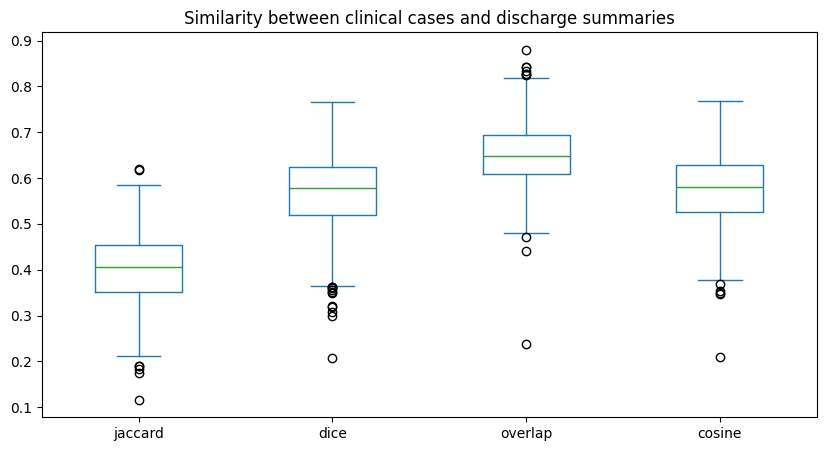

In [20]:
df_sim_word.plot(kind="box", figsize=(10, 5), title="Similarity between clinical cases and discharge summaries")

In [24]:
import textdistance

def longest_common_substring(str1, str2):
    return textdistance.lcsstr.similarity(str1, str2)

def longest_common_subsequence(str1, str2):
    return textdistance.lcsseq.similarity(str1, str2)

def greedy_string_tiling(str1, str2):
    return textdistance.ratcliff_obershelp.similarity(str1, str2)

def jaro_similarity(str1, str2):
    return textdistance.jaro.similarity(str1, str2)  # Use jellyfish for Jaro similarity

def jaro_winkler_similarity(str1, str2):
    return textdistance.jaro_winkler.similarity(str1, str2)

def monge_elkan_similarity(str1, str2):
    return textdistance.monge_elkan.similarity(str1, str2)

def levenshtein_distance(str1, str2):
    return textdistance.levenshtein.similarity(str1, str2)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

d_sim_str = {"lcstr": longest_common_substring, "lcseq": longest_common_subsequence, 
            "gst": greedy_string_tiling, "jaro": jaro_similarity, 
            "jaro_w": jaro_winkler_similarity, "monge": monge_elkan_similarity, 
            "levenshtein": levenshtein_distance}


# df_sim_str = get_similarities(df_pairs, level="word", d_sim=d_sim_str)
from datasets import Dataset
ds = Dataset.from_pandas(df_pairs)

In [44]:
# Importing evaluate library
import evaluate

# Load the BLEU and ROUGE metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

ds = ds.map(lambda x: {"bleu": bleu_metric.compute(predictions=x["discharge_summary"], references=x["clinical_case"])})


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


ValueError: Mismatch in the number of predictions (1959) and references (1509)

In [38]:
def batched_sim(batch, func):
    '''
    Compute the similarity between two strings in batches
    '''
    cc = batch["clinical_case"]
    ds = batch["discharge_summary"]
    for name, sim in d_sim_str.items():
        batch[name] = sim(cc, ds)
        
    return batch

from functools import partial
for name, sim in d_sim_str.items():
    partial_sim = partial(batched_sim, func=sim)
    ds = ds.map(partial_sim, num_proc=160, batched=True, batch_size=16)

Map (num_proc=160):   0%|          | 0/1000 [05:30<?, ? examples/s]


TimeoutError: 

In [ ]:
ds = ds.map(lambda x: {**x, **{f"cc_str": x["clinical_case"], f"ds_str": x["discharge_summary"]}})

In [ ]:
df_sim_str.plot(kind="box", figsize=(10, 5), title="String similarity between clinical cases and discharge summaries")

In [ ]:

def get_word_ngrams(text, n, tokenize=True):
    if tokenize:
        words = nltk.word_tokenize(text)
    else:
        words = text
    return list(ngrams(words, n))

def get_ngrams_similarity(x, y, sim, n=2, tokenize=True):
    ngrams1 = get_word_ngrams(x, n, tokenize=tokenize)
    ngrams2 = get_word_ngrams(y, n, tokenize=tokenize)
    return sim(ngrams1, ngrams2)

def get_ngrams_similarities(X, d_sim=None, nmax=5, tokenize=True):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"jaccard": jaccard_sim, "dice": dice_sim, 
                  "overlap": overlap_sim, "cosine": cosine_sim}

    df_sim = pd.DataFrame()
    for n in range(1, nmax+1):
        for name, sim in d_sim.items():
            df_sim[name + f"_n_{n}"] = X.apply(lambda x: get_ngrams_similarity(x["sent1"], x["sent2"], sim, n=n, tokenize=tokenize), axis=1)
        
    return df_sim

def calculate_idf(term, documents):
    document_frequency = sum(1 for document in documents if term in document)
    if document_frequency == 0:
        return 0.0
    else:
        return np.log(len(documents) / document_frequency)
    
def compare_synsets(ls_ls_syns1, ls_ls_syns2, documents=None, similarity=get_wup_similarity, idf=True):

    d_out = {}
    for w, ls_syns1 in ls_ls_syns1:
        d_out[w] = []
        for _, ls_syns2 in ls_ls_syns2:
            for syn1 in ls_syns1:
                for syn2 in ls_syns2:
                    out = similarity(syn1, syn2) if syn1.pos() == syn2.pos() else 0
                    out = 0 if out is None else out
                    d_out[w].append(out)
                    # print(syn1, syn2, out)
        
        if d_out[w] != []:
            if idf:
                d_out[w] = calculate_idf(w, documents) * np.max(d_out[w])
            else:
                d_out[w] = np.max(d_out[w])
        else:
            d_out[w] = 0

    return d_out
